# Activity 3.3: Exploring the two-grid preconditioner

5 points

**collaboration statement:**

Multigrid is not a technique for solving general systems $A x = b$: it is meant for problems where $A$ is a discretization of a PDE, where it makes sense to have to matrices, $A_h$ (the fine grid) and $A_H$ (the coarse grid) that represent the same problem.  The general idea is, like a projection problem, to use the solution of $A_H x_H = r_H$, which should be cheaper to compute because it is smaller, to generate an approximate solution $x_h$ to $A_h x = b_h$.  $b_H$ should look like $b_h$ "restricted" to the coarse grid, and $x_h$ should look like the coarse solution $x_H$ "prolonged" to the fine grid.

Multigrid techniques are only efficient if there is an approximate solver on the fine grid (the smoother) that is:

- fast to apply, and
- complementary to the coarse grid: it should efficiently reduce components of the residual that can't be well represented on the coarse grid (because they contain oscillatory details)

Whether such smoother exist is somewhat a property of the PDE that $A_h$ and $A_H$ were discretized from.  It happens that _elliptic PDEs_ have good smoothers because:

- oscillatory vectors correspond to large eigenvalues of the discretized PDEs, and
- simple preconditioners like weighted-Jacobi or Gauss-Seidel do a good job of targeting residual components with large eigenvalues

To start with, we need discretizations of the Laplacian:

In [1]:
%pip install numpy scipy matplotlib
import numpy as np
from scipy.sparse import tril, triu, diags, rand, eye, csr_matrix, kron, dia_matrix, lil_matrix
from scipy.sparse.linalg import cg, spsolve, spsolve_triangular, LinearOperator
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [2]:
def laplacian(d, n):
    """
    Args:
        d (int): dimension (1, 2, or 3)
        n (int): the number of unknowns per direction
    Returns:
        csr_matrix: the finite element Laplacian on the unit cube [0,1]^d
        with Dirichlet boundary conditions.  Matrix size is (n^d x n^d)
    """
    h = 1. / (n + 1.)
    L = (1./ h) * dia_matrix((np.array([[-1.],[2.],[-1.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
    M1 = h * dia_matrix((np.array([[1./6.],[2./3.],[1./6.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
    M2 = kron(M1, M1) 
    if d == 1:
        return csr_matrix(L)
    if d == 2:
        return csr_matrix(kron(L, M1) + kron(M1, L))
    if d == 3:
        return csr_matrix(kron(L, M2) + kron(M1, kron(L, M1)) + kron(M2, L))

In [3]:
def mass(d, n):
    """Computes the finite element mass matrix"""
    h = 1. / (n + 1.)
    M1 = h * dia_matrix((np.array([[1./6.],[2./3.],[1./6.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
    if d == 1:
        return csr_matrix(M1)
    if d == 2:
        return csr_matrix(kron(M1, M1))
    if d == 3:
        return csr_matrix(kron(M1, kron(M1, M1)))

It is typical to choose a coarse grid with the distance between grid points being twice the distance between grid points in the fine grid.  For our problem with Dirichlet boundary conditions, this corresponds to $n_h = 2n_H + 1$.

For finite element discretizations (which are themselves Galerkin projections of the function-valued PDE problem), it makes sense for the restriction and prolongation operators to be transposes of each other:

In [4]:
def intergrid_fe(d, n_H):
    """Prolongation and restriction operators for our finite element problem"""
    n_h = 2 * n_H + 1
    P = lil_matrix((n_h, n_H))
    for i in range(n_H):
        P[2*i, i] = 0.5
        P[2*i + 1, i] = 1.0
        P[2*i + 2, i] = 0.5
    P = csr_matrix(P)
    P1 = P.copy()
    for i in range(d-1):
        P = csr_matrix(kron(P, P1))
    R = csr_matrix(P.T)
    return P, R

One thing to notice about this finite element problem is that rediscretizing $L_H$ is the same as computing
the Galerkin projection, $L_H = R L_h P$

In [5]:
n_H = 5
n_h = 2 * n_H + 1
L_H = laplacian(3,n_H)
L_h = laplacian(3,n_h)
P, R = intergrid_fe(3,n_H)
L_G = R @ L_h @ P # G for Galerkin
print(np.linalg.norm((L_H - L_G).toarray()))

1.2875435036361366e-15


Now we write out the basic two-grid preconditioner:

1. smooth the existing residual
2. restrict the smoothed residual to the coarse grid
3. solve the coarse grid problem for the restricted residual 
4. prolong the coarse grid solution as the coarse grid correction on the fine grid
5. smooth again on the fine grid

In [6]:
def two_grid(A_h, A_H, R, P, b_h, x_h0, pre_smoother, coarse_solver, post_smoother):
    """
    A_h: fine grid
    A_H: coarse grid
    R: restriction
    P: prolongation
    b_h: fine grid rhs
    x_h0: fine grid initial solution
    """
    r_h0 = b_h - A_h @ x_h0
    d_h0 = pre_smoother(A_h, r_h0)
    x_h1 = x_h0 + d_h0
    r_h1 = b_h - A_h @ x_h1
    r_H = R @ r_h1
    d_H = coarse_solver(A_H, r_H)
    d_h1 = P @ d_H
    x_h2 = x_h1 + d_h1
    r_h2 = b_h - A_h @ x_h2
    d_h2 = post_smoother(A_h, r_h2)
    return x_h2 + d_h2

Here is some code to estimate the convergence factor of the two grid preconditioner and plot it for increasing grid sizes in 2D

In [7]:
def estimate_convergence_factor(n, A, P, M, ntrials=30):
    max_post = 0.
    for i in range(ntrials):
        if i == 0:
            g = np.ones((n,))
        else:
            g = np.random.randn(n)
        b = M @ g
        normpre = np.linalg.norm(b)
        x = P(b)
        r = b - A @ x
        normpost = np.linalg.norm(r)
        factor = normpost / normpre
        max_post = max(max_post, factor)
    return max_post

In [8]:
def plot_convergence_factors(pre_smoother, coarse_solver, post_smoother):
    d = 2
    n_Hs = [2, 4, 8, 16, 32, 64]
    factors = []
    for n_H in n_Hs:
        L_H = laplacian(d, n_H)
        n_h = 2 * n_H + 1
        L_h = laplacian(d, n_h)
        P, R = intergrid_fe(d, n_H)
        x0 = np.zeros(L_h.shape[0])
        prec = lambda b: two_grid(L_h, L_H, R, P, b, x0, pre_smoother, coarse_solver, post_smoother)
        M = mass(d, n_h)
        factor = estimate_convergence_factor(L_h.shape[0], L_h, prec, M)
        factor = min(1., factor)
        factors.append(factor)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="Two grid convergence factors")
    ax.set(xlabel="n_H")
    ax.set(ylabel="rho")
    ax.set(ylim=(0,1))
    plt.semilogx(n_Hs, factors)

Here is an example for estimating the convergence for the two-grid preconditioner, pre- and post-smoothed by one iteration of undamped Jacobi, using a fairly exact CG iteration as the coarse solve.

We see _h-independent convergence_ if the convergence factor is bounded away from 1 as $h$ increases.

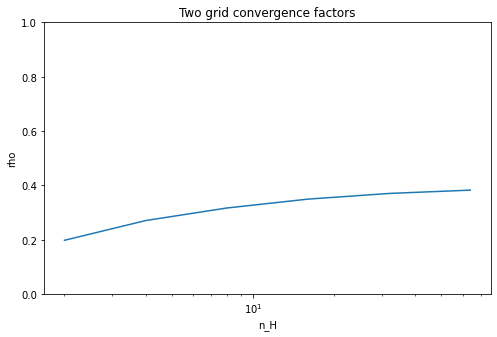

In [9]:
pre_smoother = lambda A, r: r / A.diagonal()
post_smoother = pre_smoother
coarse_solver = lambda A, r: cg(A, r, tol=1.e-12)[0]
plot_convergence_factors(pre_smoother, coarse_solver, post_smoother)

**Activity 1 (2 points):** Replace Jacobi with damped jacobi, $x \gets \omega * \text{diag}(A)^{-1} r$.  Try to find:

1. The largest $\omega$ that shows $h$-independent convergence,

In [10]:
L_h = laplacian(2, 32)
D = L_h.diagonal()
A = diags(1./D) @ L_h
A = A.toarray()
np.max(np.abs(np.linalg.eigvals(A)))

1.495482174315677

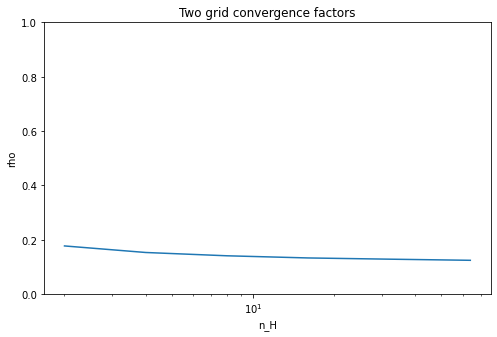

In [13]:
omega = 1.0 / 1.5
pre_smoother = lambda A, r: omega * r / A.diagonal()
post_smoother = pre_smoother
coarse_solver = lambda A, r: cg(A, r, tol=1.e-12)[0]
plot_convergence_factors(pre_smoother, coarse_solver, post_smoother)

2. The $\omega$ that gives the best convergence rate

In [12]:
omega = 1.0 / 1.5
pre_smoother = lambda A, r: omega * r / A.diagonal()
post_smoother = pre_smoother
coarse_solver = lambda A, r: cg(A, r, tol=1.e-12)[0]
plot_convergence_factors(pre_smoother, coarse_solver, post_smoother)

NotImplementedError: 

**Activity 2 (1 point):** Using the best damped Jacobi $\omega$ that you found, try to find the largest tolerance for the coarse solve for which you observe $h$-independent convergence.

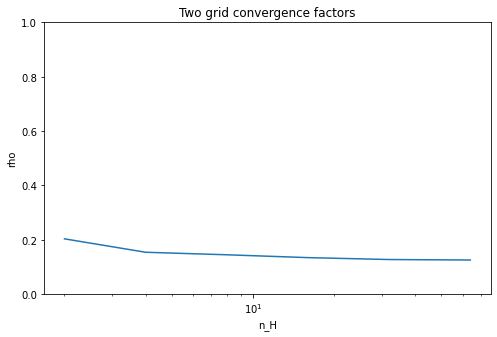

In [16]:
omega = 1.0 / 1.5
pre_smoother = lambda A, r: omega * r / A.diagonal()
post_smoother = pre_smoother
coarse_solver = lambda A, r: cg(A, r, tol=1.e-3)[0]
plot_convergence_factors(pre_smoother, coarse_solver, post_smoother)

**Activity 3 (2 point):** Using the optimal $\omega$ and coarse solve tolerance you found, compare the convergence:

1. Using only presmoothing:

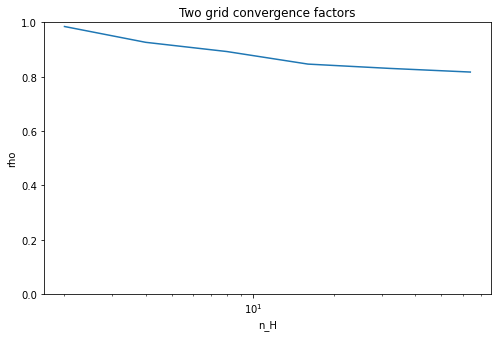

In [17]:
omega = 1.0 / 1.5
pre_smoother = lambda A, r: np.zeros(r.shape)
post_smoother = pre_smoother
coarse_solver = lambda A, r: cg(A, r, tol=1.e-3)[0]
plot_convergence_factors(pre_smoother, coarse_solver, post_smoother)

2. Using only post smoothing:

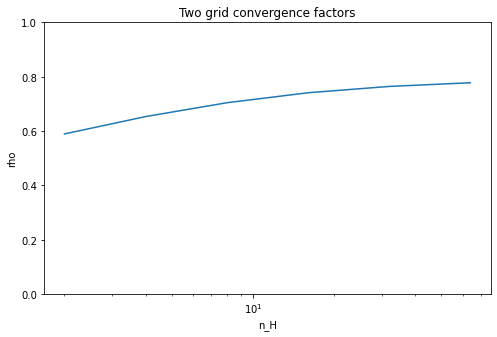

In [18]:
omega = 1.0 / 1.5
pre_smoother = lambda A, r: omega * r / A.diagonal()
post_smoother = lambda A, r: np.zeros(r.shape)
coarse_solver = lambda A, r: cg(A, r, tol=1.e-3)[0]
plot_convergence_factors(pre_smoother, coarse_solver, post_smoother)